In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import requests
from lxml import etree
import json
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [6]:
# 爬虫准备
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/14.0.835.163 Safari/535.1'}
req=requests.get('https://ncov.dxy.cn/ncovh5/view/pneumonia?from=timeline&isappinstalled=0', headers=headers, timeout=3)
req.encoding="utf-8"#防止中文乱码
print(req)
html=etree.HTML(req.text)
req_data=html.xpath("//*[@id='getListByCountryTypeService2true']/text()")
city_data = html.xpath("//*[@id='getAreaStat']/text()")

<Response [200]>


In [13]:
#提取字符串
req_str=req_data[0]+''
data_str=req_str[req_str.find('[{'):req_str.find('}catch')]
data_json=json.loads(data_str)#转化为json
countryJsonList=[]#国家疫情数据存储json列表
for i in data_json:
    #中国、美国、巴西、印度、俄罗斯、法国、英国、土耳其、阿根廷、哥伦比亚
    if i["provinceName"] in ['中国','美国','巴西','印度','俄罗斯','英国','法国','土耳其','阿根廷','哥伦比亚']:
        countryJsonList.append([i['provinceName'],i['statisticsData']])

city_str=city_data[0]+''
cityData_str=city_str[city_str.find('[{'):city_str.find('}catch')]
cityData_json=json.loads(cityData_str)#转化为json
cityJsonList=[]#国家疫情数据存储json列表
for i in cityData_json:
    if i["provinceShortName"] in ['内蒙古', '台湾', '广西', '浙江', '澳门', '甘肃', '西藏', '香港', '北京', '重庆', '上海',
        '天津', '湖北', '四川', '吉林', '山东', '广东', '福建', '海南', '江苏', '宁夏', '湖南',
        '河北', '河南', '辽宁', '安徽', '云南', '江西', '陕西', '山西', '贵州', '黑龙江', '青海',
        '新疆']:
        cityJsonList.append([i['provinceShortName'],i['statisticsData']])

In [14]:
#下载json
def downloadJson(jsonList):
    for i in jsonList:
        cityName=i[0]
        jsonAddress=i[1]
        try:
            r=requests.get(jsonAddress,headers=headers, timeout=3)
            r.raise_for_status()
            r.encoding = "utf-8" # 防止中文乱码
            CityDataJson = json.loads(r.text)
            toWriteFilePath = 'work/'+cityName+ '.json'
            with open(toWriteFilePath, 'w',encoding='UTF-8') as file:
                json.dump(CityDataJson, file, ensure_ascii=False)
            print(cityName + "数据已下载！")
        except:
            print("在获取 "+cityName+" 数据时出错！")

In [15]:
# 得到csv文件
def getCount(nameList, Class, sign):
    for j in Class:
        temp = []
        for i in nameList:
            file = 'work/'+i+'.json'
            with open(file,'r') as f:
                data = json.load(f)
                data_list = data['data']
                data_df = pd.DataFrame(data_list)
                data_df.set_index('dateId',inplace = True)
                data_df = data_df[[j]]
                data_ult = data_df[data_df.index>20210600]
                data_ult = data_ult[data_ult.index<20210828]
                data_ult = data_ult.replace(0, np.nan)
                data_ult = data_ult.T
                data_ult.index = [i]
                # print(data_ult)
                temp.append(data_ult)
                data_ult.bfill(inplace = True)
                # data_ult.to_csv('work/'+i+'.csv')
        result = pd.concat(temp)
        result.to_csv('work/'+sign+j+'.csv')

In [16]:
# 数据爬取
downloadJson(cityJsonList)
downloadJson(countryJsonList)
country = ['中国', '俄罗斯', '印度', '哥伦比亚', '土耳其', '巴西', '法国', '美国', '英国', '阿根廷']
city = ['内蒙古', '台湾', '广西', '浙江', '澳门', '甘肃', '西藏', '香港', '北京', '重庆', '上海',
        '天津', '湖北', '四川', '吉林', '山东', '广东', '福建', '海南', '江苏', '宁夏', '湖南',
        '河北', '河南', '辽宁', '安徽', '云南', '江西', '陕西', '山西', '贵州', '黑龙江', '青海',
        '新疆']
Class = ['confirmedCount','curedCount','deadCount']
getCount(country, Class, 'World_')
getCount(city, Class, 'City_')

台湾数据已下载！
云南数据已下载！
上海数据已下载！
香港数据已下载！
广东数据已下载！
湖南数据已下载！
浙江数据已下载！
河南数据已下载！
湖北数据已下载！
天津数据已下载！
福建数据已下载！
山东数据已下载！
江苏数据已下载！
四川数据已下载！
北京数据已下载！
广西数据已下载！
辽宁数据已下载！
陕西数据已下载！
黑龙江数据已下载！
内蒙古数据已下载！
山西数据已下载！
澳门数据已下载！
重庆数据已下载！
河北数据已下载！
安徽数据已下载！
新疆数据已下载！
江西数据已下载！
吉林数据已下载！
甘肃数据已下载！
海南数据已下载！
贵州数据已下载！
宁夏数据已下载！
青海数据已下载！
西藏数据已下载！
美国数据已下载！
英国数据已下载！
法国数据已下载！
俄罗斯数据已下载！
印度数据已下载！
土耳其数据已下载！
巴西数据已下载！
阿根廷数据已下载！
哥伦比亚数据已下载！
中国数据已下载！


In [7]:
# 文件读取与数据整理
W_curedCount = pd.read_csv('work/World_curedCount.csv')
W_confirmedCount = pd.read_csv('work/World_confirmedCount.csv')
W_deadCount = pd.read_csv('work/World_deadCount.csv')
C_curedCount = pd.read_csv('work/City_curedCount.csv')
C_confirmedCount = pd.read_csv('work/City_confirmedCount.csv')
C_deadCount = pd.read_csv('work/City_deadCount.csv')
data1 = [W_curedCount, W_confirmedCount, W_deadCount]
for data in data1:
    data.iloc[:, 0] = ['China', 'Russia', 'India', 'Colombia', 'Turkey', 'Brazil', 'France', 
 'United States',' United Kingdom ',' Argentina ']  # 将名称改为英文，防止中文显示乱码
    data.fillna(method='ffill',axis=0, inplace=True)  # 对空数据使用前一个值进行填充
data2 = [C_curedCount, C_confirmedCount, C_deadCount]
for data in data2:
    data.iloc[:, 0] = ['Inner Mongolia','Taiwan ', 'Guangxi', 'Zhejiang', 'Macao ', 'Gansu', 'Tibet ', 'Hong Kong', 'Beijing',
 'Chongqing', 'Shanghai ','Tianjin ', 'Hubei', 'Sichuan ', 'Jilin', 'Shandong ', 'Guangdong', 'Fujian', 'Hainan', 'Jiangsu',
 'Ningxia', 'Hunan', 'Hebei', 'Henan', 'Liaoning', 'Anhui', 'Yunnan', 'Jiangxi', 'Shaanxi ', 'Shanxi ', 'Guizhou',
 'Heilongjiang', 'Qinghai', 'Xinjiang']
    data.fillna(method='ffill',axis=0, inplace=True)


In [8]:
datas = [W_deadCount, W_curedCount, W_confirmedCount, C_confirmedCount, C_curedCount, C_deadCount]
for data in datas:
    data['total'] = data.max(axis=1)
cityNum = C_confirmedCount.shape[0]  # 城市数量
city_name = C_confirmedCount.iloc[:, 0]  # 城市名称
countryNum = W_deadCount.shape[0]  # 国家数量
country_name = W_deadCount.iloc[:, 0]  # 国家名称
city_cured = C_curedCount.loc[:, 'total']
city_dead = C_deadCount.loc[:, 'total']
city_confirmed = C_confirmedCount.loc[:, 'total']
world_cures = W_curedCount.loc[:, 'total']
world_dead = W_deadCount.loc[:, 'total']
world_confirmed = W_confirmedCount.loc[:, 'total']

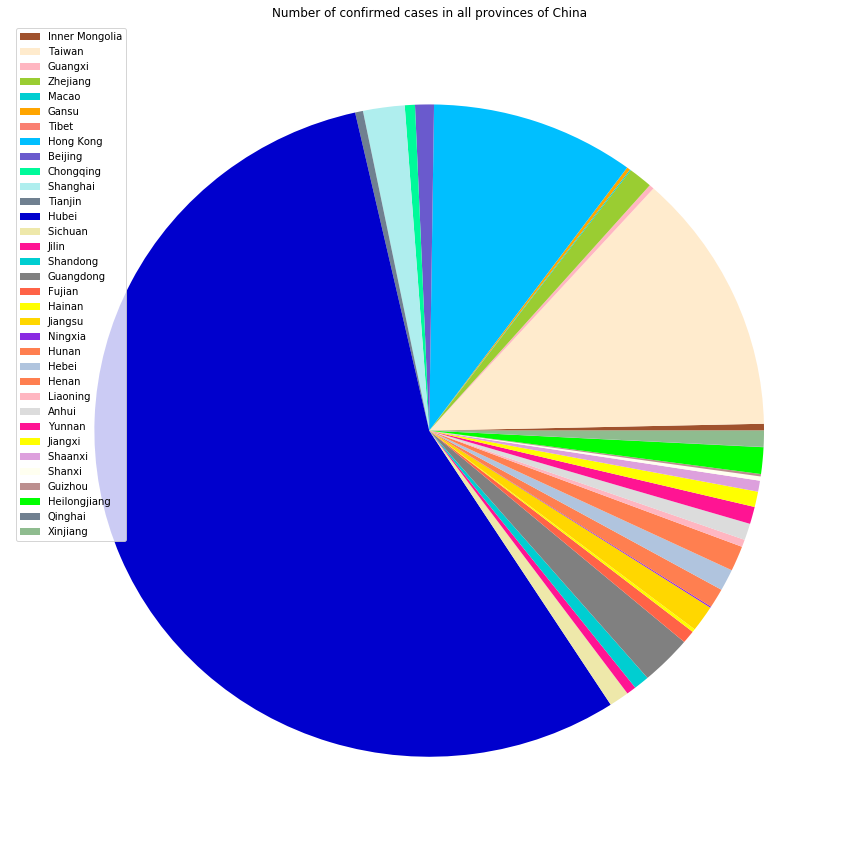

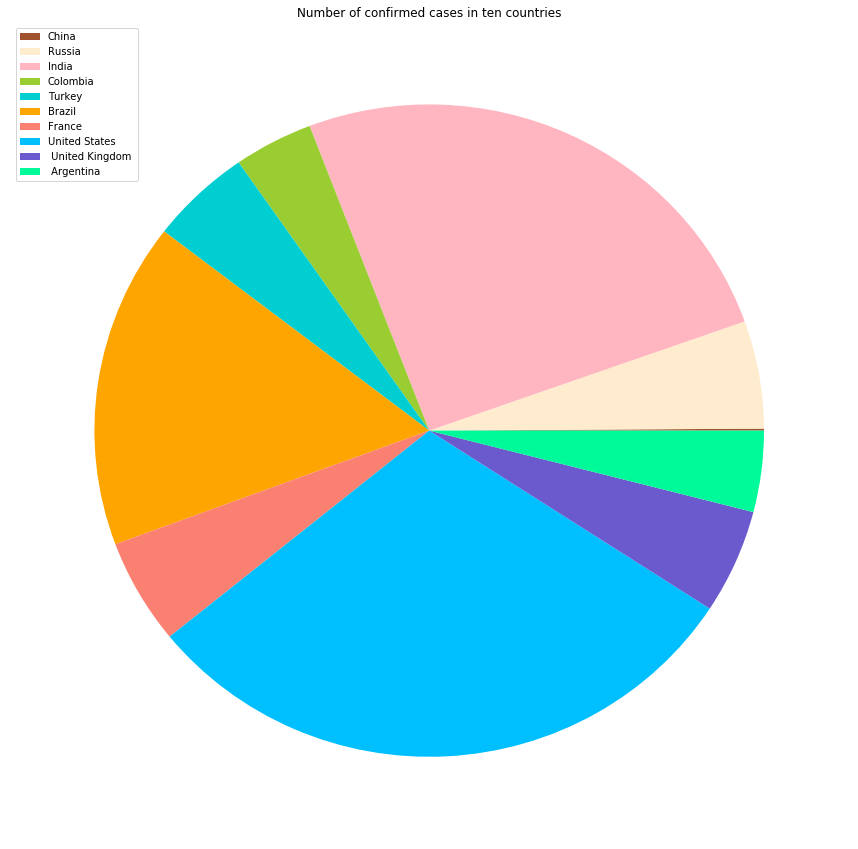

In [39]:
# 累计确诊病例数
# 中国各省确诊
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = cityNum)
plt.figure(figsize=(15,15))
plt.pie(city_confirmed, colors=c)
plt.legend(city_name, loc='best')
plt.title('Number of confirmed cases in all provinces of China')
plt.show()
# 十个国家确诊
plt.figure(figsize=(15,15))
plt.pie(world_confirmed, colors=c)
plt.legend(country_name, loc='best')
plt.title('Number of confirmed cases in ten countries')
plt.show()

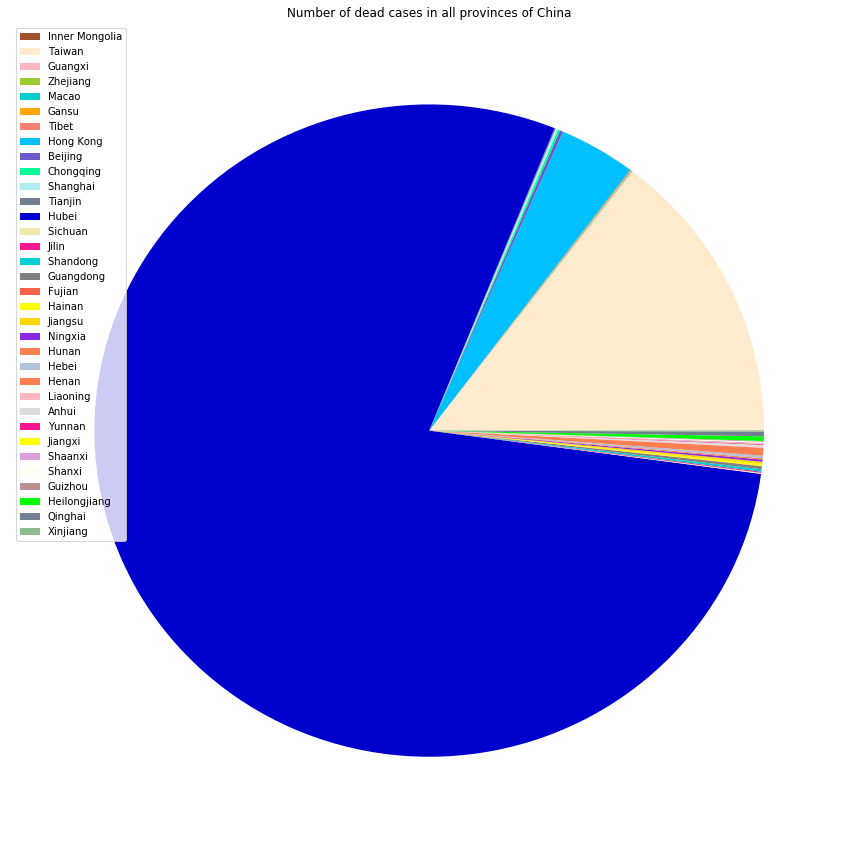

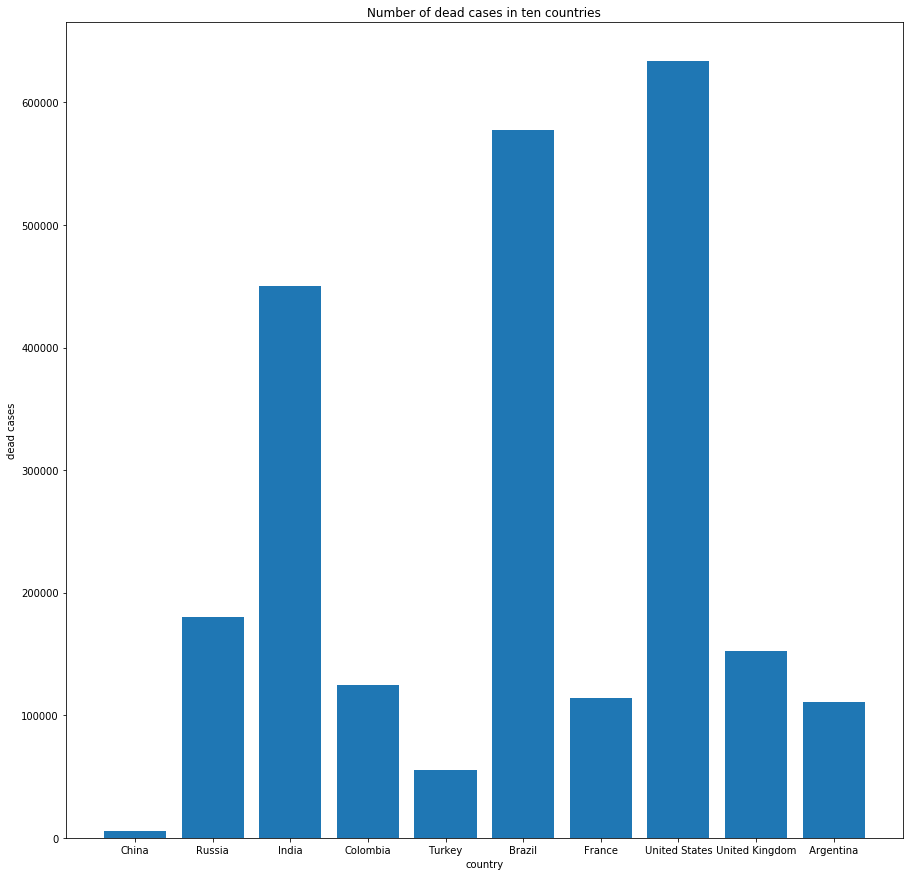

In [41]:
# 累计死亡人数
# 中国各省市
plt.figure(figsize=(15,15))
plt.pie(city_dead, colors=c)
plt.legend(city_name, loc='best')
plt.title('Number of dead cases in all provinces of China')
plt.show()
# 十个国家
plt.figure(figsize=(15,15))
plt.bar(country_name, world_dead)
plt.xlabel("country")
plt.ylabel("dead cases")
plt.title('Number of dead cases in ten countries')
plt.show()

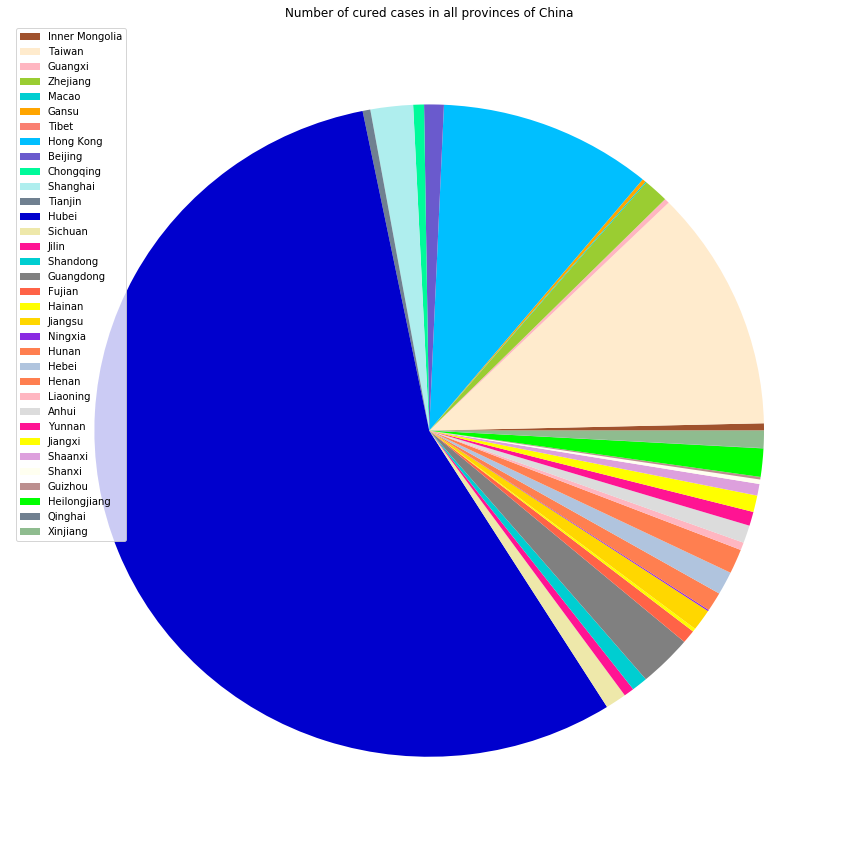

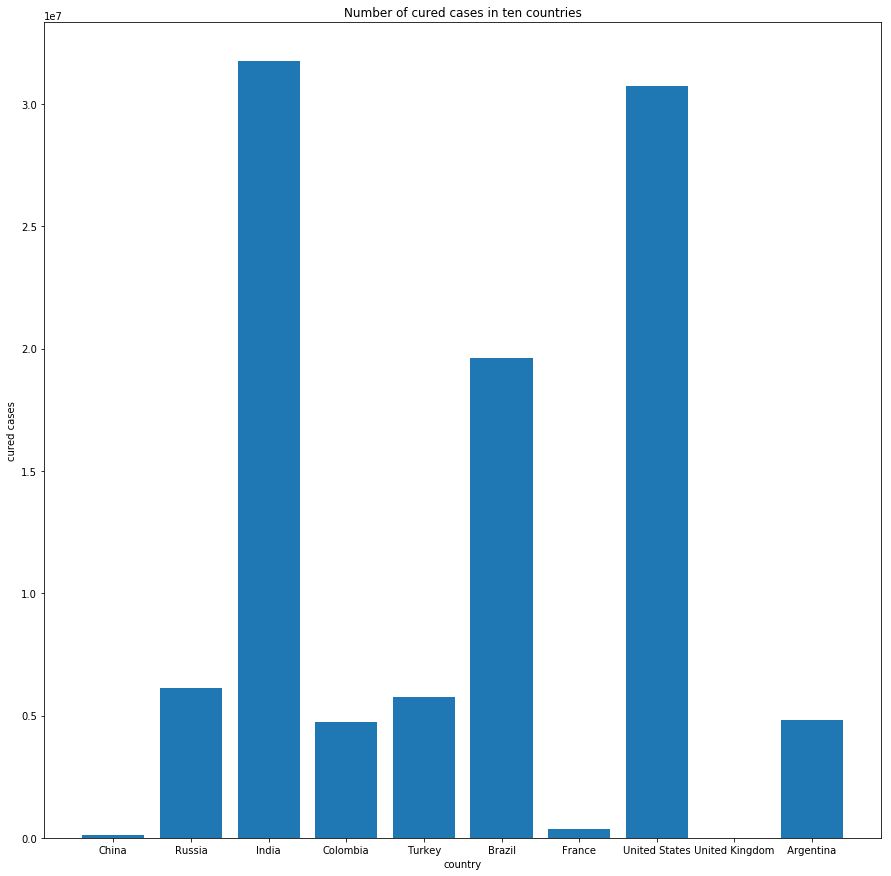

In [42]:
# 累计治愈人数
# 中国各省市
plt.figure(figsize=(15,15))
plt.pie(city_cured, colors=c)
plt.legend(city_name, loc='best')
plt.title('Number of cured cases in all provinces of China')
plt.show()
# 十个国家
plt.figure(figsize=(15,15))
plt.bar(country_name, world_cures)
plt.xlabel("country")
plt.ylabel("cured cases")
plt.title('Number of cured cases in ten countries')
plt.show()

In [9]:
# 划分训练集与测试集
date = C_confirmedCount.columns[1:-1]
X_train = np.array([i for i in range(1, len(date)+1)]).reshape(-1, 1)  # 1-88
y_train = W_confirmedCount.iloc[0, 1:89]
testData = pd.read_csv('work/China_test.csv')
y_test = testData.loc[:, 'confirmedCount']
X_test = np.arange(89,98).reshape(-1, 1)  # 89-97

In [23]:
# 使用SVR模型进行预测
kernel = ['linear', 'rbf', 'sigmoid']
c = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.001, 0.01, 0.1, 1]
epsilon = [0.001, 0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}
svm = SVR()
# 使用随机搜索进行超参优化
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train, y_train)
svm_search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished


{'shrinking': True, 'kernel': 'linear', 'gamma': 1, 'epsilon': 0.001, 'C': 10}

SVM预测的r2为： -52.57644387542103
SVM预测的结果为 [123387.54390909 123476.60445454 123565.665      123654.72554545
 123743.78609091 123832.84663636 123921.90718182 124010.96772727
 124100.02827273]


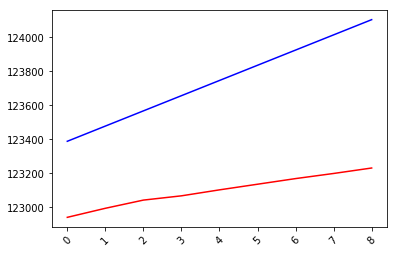

In [29]:
svm_confirmed = svm_search.best_estimator_
svm_test_pred = svm_confirmed.predict(X_test)
plt.plot(svm_test_pred,'b')
plt.plot(y_test,'r')
plt.xticks(rotation=45)
print('SVM预测的r2为：', r2_score(y_test,svm_test_pred))
print('SVM预测的结果为', svm_test_pred)

In [25]:
# 线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)

线性回归预测的r2为： -134.8300037379913
线性回归预测的结果为： [123734.09247649 123834.61677116 123935.14106583 124035.6653605
 124136.18965517 124236.71394984 124337.23824451 124437.76253918
 124538.28683386]


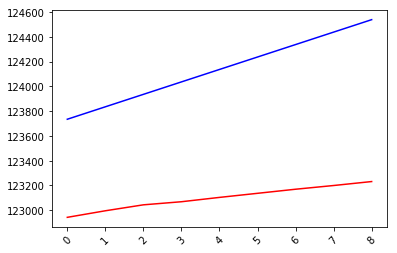

In [26]:
plt.plot(test_linear_pred,'b')
plt.plot(y_test,'r')
plt.xticks(rotation=45)
print('线性回归预测的r2为：', r2_score(y_test,test_linear_pred))
print('线性回归预测的结果为：', test_linear_pred)

逻辑回归预测的r2为： -4.9846818538884525
逻辑回归预测的结果为： [122897 122897 122897 122897 122897 122897 122897 122897 122897]


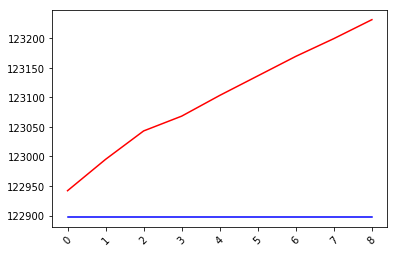

In [30]:
# 使用逻辑回归模型
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, list(y_train))
logistic_pre = lr.predict(X_test)
plt.plot(logistic_pre,'b')
plt.plot(y_test,'r')
plt.xticks(rotation=45)
print('逻辑回归预测的r2为：', r2_score(y_test,logistic_pre))
print('逻辑回归预测的结果为：', logistic_pre)

多项式预测的r2为： -54.605635234536656
多项式预测的结果为： [122810.17380176 122774.00789356 122723.11761582 122656.58209109
 122573.45633805 122472.7712716  122353.53370282 122214.72633893
 122055.30778337]


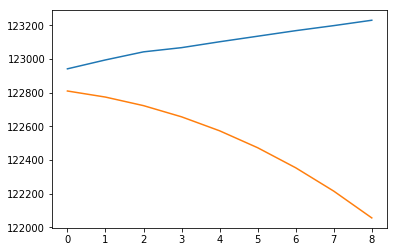

In [10]:
# 通过多项式函数进行拟合，四次多项式过拟合
# 有拟合没预测
poly = PolynomialFeatures(4)
poly.fit(X_train)
poly.fit(X_test)
x_test = poly.fit_transform(X_test) 
x_train = poly.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(x_train,list(y_train))
y_test_pre = lin_reg.predict(x_test)
plt.plot(y_test)
plt.plot(y_test_pre)
print('多项式预测的r2为：', r2_score(y_test,y_test_pre))
print('多项式预测的结果为：', y_test_pre)

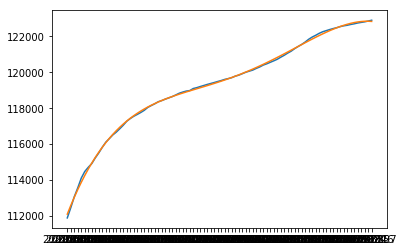

In [15]:
plt.plot(y_train)
plt.plot(lin_reg.predict(x_train))

逻辑增长函数的r2为： 0.8656936151939529
逻辑增长函数的结果为： [122902.02908665 122951.85702785 123000.92861889 123049.25473503
 123096.84611389 123143.71335666 123189.86692919 123235.31716323
 123280.07425756]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


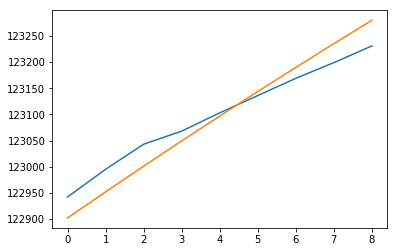

In [36]:
# 逻辑增长函数进行数据拟合，0.86
def logistic_increase_function(t,K,P0,r):
    t0=1
    r = 0.0161
    exp_value=np.exp(r*(t-t0))
    return (K*exp_value*P0)/(K+(exp_value-1)*P0)
time_array = np.array(X_train).reshape(88)
confirm_array = np.array(y_train)
long_time_array = np.array(X_test).reshape(9)
# 现有数据曲线拟合预测
popt, pcov = curve_fit(logistic_increase_function, time_array, confirm_array)
#获取popt里面是拟合系数
#拟合后预测的P值
P_predict = logistic_increase_function(long_time_array,popt[0],popt[1],popt[2])
print('逻辑增长函数的r2为：', r2_score(y_test,P_predict))
print('逻辑增长函数的结果为：', P_predict)
plt.plot(y_test)
plt.plot(P_predict)

In [177]:
# 用每个省份的进行单独预测，将预测结果求和得到全国新增，多次随机搜索参数
# 由于是随即搜索参数，结果有随机性
# 多次运行后得到最优结果为0.964
r2 = 0
while r2<=0.96:
    b = []
    arr = []
    param_list = []
    for i in range(34):
        y_train = C_confirmedCount.iloc[i, 1:89]
        y_dif_train = np.array(y_train[1:89]) - np.array(y_train[0:87])
        # print(y_dif_train)
        kernel = ['linear', 'rbf', 'sigmoid']
        c = [0.001, 0.01, 0.1, 1, 10]
        gamma = [0.001, 0.01, 0.1, 1]
        epsilon = [0.001, 0.01, 0.1, 1]
        shrinking = [True, False]
        svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}
        # 建立支持向量回归模型
        svm = SVR()
        # 使用随机搜索进行超参优化
        svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
        y_dif_train = np.sqrt(y_dif_train.astype('int'))
        y_dif_train[np.isnan(y_dif_train)]=0
        svm_search.fit(X_dif_train, y_dif_train)
        param_list.append(svm_search.best_params_)
        svm_confirmed = svm_search.best_estimator_
        svm_test_pred = svm_confirmed.predict((X_dif_test))
        arr.append(svm_test_pred**2)
    a = np.array(arr)
    # np.sum(a, axis=0)
    a = np.sum(a, axis=0)
    b.append(W_confirmedCount.iloc[0,-1]+a[0])
    for i in range(1, 9):
        b.append(b[i-1]+a[i])
    r2 = r2_score(y_test,b)
    print(r2)

In [187]:
# r2为0.964时，各省的适宜参数
param_list

[{'shrinking': True,
  'kernel': 'sigmoid',
  'gamma': 0.1,
  'epsilon': 0.001,
  'C': 10},
 {'shrinking': False,
  'kernel': 'linear',
  'gamma': 0.1,
  'epsilon': 0.01,
  'C': 0.001},
 {'shrinking': True,
  'kernel': 'sigmoid',
  'gamma': 0.001,
  'epsilon': 0.1,
  'C': 0.1},
 {'shrinking': False, 'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.1, 'C': 10},
 {'shrinking': False,
  'kernel': 'rbf',
  'gamma': 0.01,
  'epsilon': 0.1,
  'C': 0.01},
 {'shrinking': False,
  'kernel': 'sigmoid',
  'gamma': 0.001,
  'epsilon': 0.1,
  'C': 0.1},
 {'shrinking': True,
  'kernel': 'sigmoid',
  'gamma': 0.1,
  'epsilon': 0.1,
  'C': 0.01},
 {'shrinking': False, 'kernel': 'rbf', 'gamma': 1, 'epsilon': 1, 'C': 0.1},
 {'shrinking': False, 'kernel': 'rbf', 'gamma': 0.001, 'epsilon': 0.1, 'C': 1},
 {'shrinking': False,
  'kernel': 'sigmoid',
  'gamma': 0.1,
  'epsilon': 0.001,
  'C': 10},
 {'shrinking': False,
  'kernel': 'sigmoid',
  'gamma': 0.01,
  'epsilon': 0.1,
  'C': 0.1},
 {'shrinking': False,
  'k

In [188]:
# r2为0.964时的预测结果
b

[122934.55996420381,
 122972.31145833316,
 123010.28214361647,
 123048.52188980427,
 123087.07896363386,
 123125.99616302577,
 123165.31017460852,
 123205.05270164201,
 123245.25276617178]

In [17]:
# 通过各省每天确诊人数的差值进行预测
y_dif_train = np.array(y_train[1:89]) - np.array(y_train[0:87])
X_dif_train = np.arange(1, 88).reshape(-1, 1)
X_dif_test = np.arange(88, 97).reshape(-1, 1)
svr = SVR(kernel='linear')
# 为了能够更好的进行训练使用np.log对Y值进行处理
svr.fit(X_dif_train, np.log(y_dif_train.astype('int'))) #  0.97 linear
# svr.fit(X_dif_train, np.sqrt(y_dif_train.astype('int')))# 0.94 linear 0.92rbf
dif_pre = svr.predict(X_dif_test)

SVR使用linear核函数的测试r2为 0.9741320881860522
SVR使用linear核函数的测试结果为 [122940.06822596096, 122982.3361783742, 123023.81872754633, 123064.53046747152, 123104.48572096576, 123143.69854470351, 123182.18273416694, 123219.9518284954, 123257.01911525083]


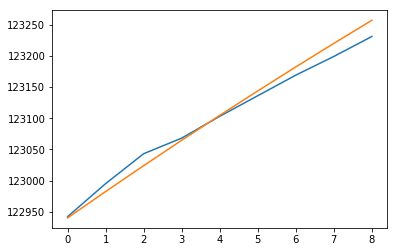

In [18]:
dif_svr_pre = []
dif_svr_pre.append(y_train[-1]+np.exp(dif_pre[0]))
for i in range(1, 9):
    dif_svr_pre.append(dif_svr_pre[i-1]+np.exp(dif_pre[i]))
r2 = r2_score(y_test,dif_svr_pre)
plt.plot(y_test)
plt.plot(dif_svr_pre)
print('SVR使用linear核函数的测试r2为', r2)
print('SVR使用linear核函数的测试结果为', dif_svr_pre)

In [20]:
print('预测结果为：', dif_svr_pre)

预测结果为： [122940.06822596096, 122982.3361783742, 123023.81872754633, 123064.53046747152, 123104.48572096576, 123143.69854470351, 123182.18273416694, 123219.9518284954, 123257.01911525083]


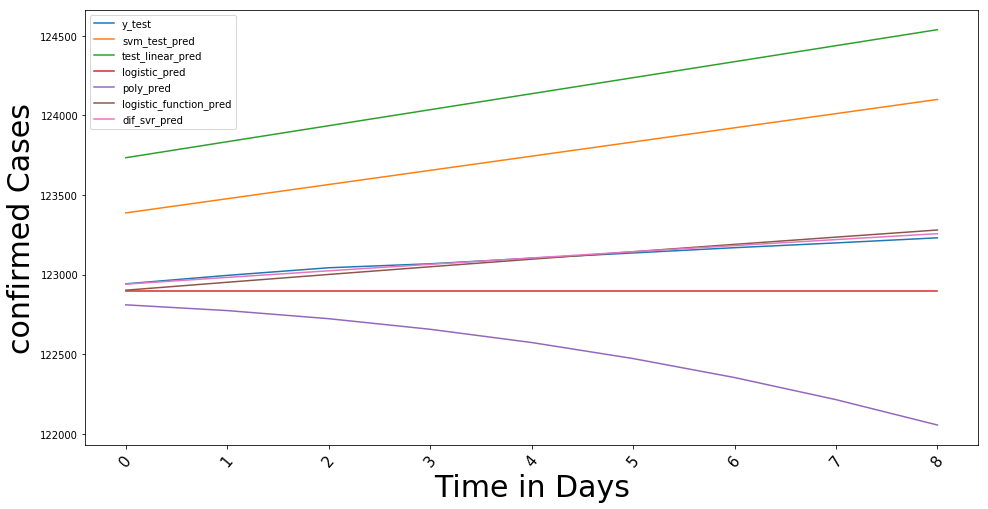

In [50]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(svm_test_pred)
plt.plot(test_linear_pred)
plt.plot(logistic_pre)
plt.plot(y_test_pre)
plt.plot(P_predict)
plt.plot(dif_svr_pre)
plt.xlabel('Time in Days', size=30)
plt.ylabel('confirmed Cases', size=30)
plt.legend(['y_test', 'svm_test_pred', 'test_linear_pred', 'logistic_pred', 'poly_pred', 'logistic_function_pred', 'dif_svr_pred'])
plt.xticks(rotation=50, size=15)
plt.show()